<h1 align="center">INET4061 Project</h1>
<h1 align="center">Facial Recognition: identifying name and emotion</h1>
<h3 align="center">Ruoyun Chen, Yangjiawen Xu</h3>
<h3 align="center">Nov 30, 2018</h3>

## Overview

TODO: Add another sentence at the beginning of the overview that summarizes what your analysis is about.

In this project, we divide it into two parts. The first part is about identifying name. The second part is about identifyiuse the dataset 'the labled face in the wild' to identify the name and use the JAFFE dataset and labeled face in the wild to facial expression recognition.

The fist task of face recognition in this project is identifying a person from an image of the person's face. This can be treated as a classification problem where we assign the person's name to an image of a face.

To identify the name,
- Preprocessing data with PCA
- Train a SVM model
- Hyper-parameters tuning using a Cross-Validated Grid Search
- Plot the images on test set
- Evaluation

The second task of face recognition is to identify a person's emotions.This can also be treated as a classification problem where we assign the person's emotion to an image of a face. 

To identify the emotions,
- Preprocess data 
- Use representational autoencoder units to classify an image among one of the seven different emotions
- Create CNN Layer Set
- Train on the JAFFE dataset
- Test on the labeled faces in the wild dataset
- Evaluation

Reference:
+ https://github.com/orlandopython/ML-Workshop/blob/09af4cf135a77b5397f3ea532ddf8d2b3950b46a/Eigen%20Faces.ipynb
+ http://nbviewer.jupyter.org/github/ogrisel/notebooks/blob/master/Labeled%20Faces%20in%20the%20Wild%20recognition.ipynb
+ https://github.com/pckuo/hands_on_ML/blob/bb07420d5f3e6686157ed3ea683d5dffbc6cf281/exercise/ex07_application_to_face_recognition.ipynb
+ 
https://github.com/ashishpatel26/Facial-Expression-Recognization-using-JAFFE
+ 
https://github.com/nicolascerna/emotion-recognition-example
+ 
https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python

Data Source:
+ http://vis-www.cs.umass.edu/lfw/#information
+ http://www.kasrl.org/jaffe.html

In [16]:
%pylab inline

import pylab as pl
import numpy as np
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import keras

from keras.utils import np_utils

from keras import backend as K

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from keras import backend as K

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.preprocessing.image import ImageDataGenerator

from skimage.feature import local_binary_pattern as lbp
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import KFold as KF
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['title', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


ModuleNotFoundError: No module named 'keras'

## Part I : Identify Name

## Data
### LFW
Labeled Faces in the Wild is a dataset of face photographs designed for studying the problem of unconstrained face recognition. The data set contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. More details can be found in http://vis-www.cs.umass.edu/lfw.

We use a subset of this dataset to identify face.

In [3]:
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                                       data_home='datasets')

In [4]:

X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

n_samples, n_features = X.shape
_, h, w = lfw_people.images.shape
print("image shape: h={0}, w={1}".format(h,w))
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))

image shape: h=50, w=37
n_samples: 1288
n_features: 1850
n_classes: 7


n_classes is the number of distinct names.

Visualize these faces: 

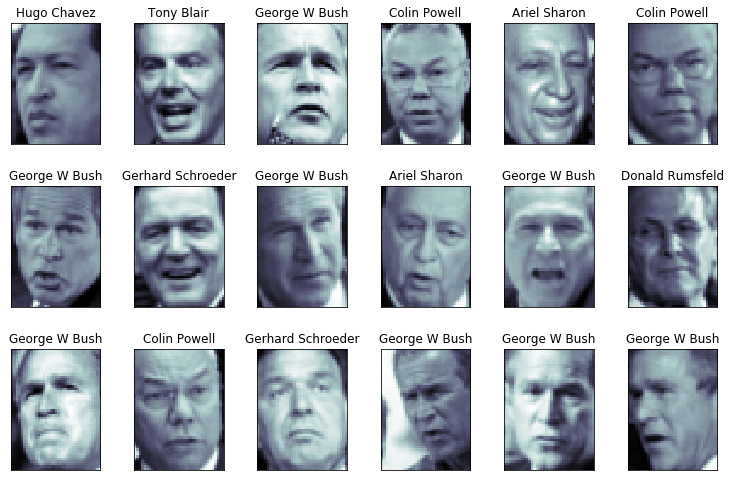

In [5]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.bone)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

plot_gallery(X, names[y], h, w)

## Exploratory Data Analysis

Let's have a look at the repartition among target classes:

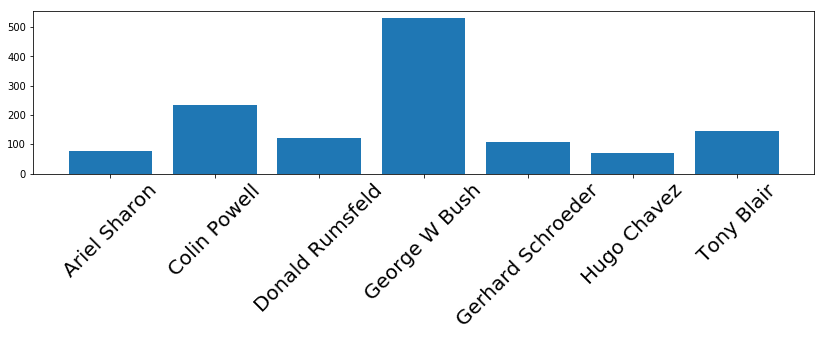

In [6]:

pl.figure(figsize=(14, 3))

y_unique = np.unique(y)
counts = [(y == i).sum() for i in y_unique]

pl.xticks(y_unique,  names[y_unique])
locs, labels = pl.xticks()
pl.setp(labels, rotation=45, size=20)
_ = pl.bar(y_unique, counts)

We'll do a typical train-test split on the images to make this happen:

In [7]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(lfw_people.data, lfw_people.target, random_state=0)

print(X_train.shape, X_test.shape)


(966, 1850) (322, 1850)


1850 dimensions is a lot for SVM. We can use PCA to reduce these 1850 features to a manageable size, while maintaining most of the information in the dataset. Here it is useful to use a variant of PCA called RandomizedPCA, which is an approximation of PCA that can be much faster for large datasets. The interface is the same as the normal PCA we saw earlier. 

The reason we chose PCA "eigenfaces" as a pre-processing step is because PCA is a broadly-applicable technique, which can be useful for a wide array of data types. 

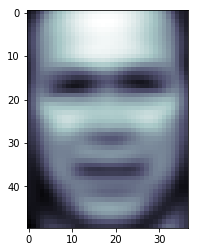

In [8]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=150, whiten=True, svd_solver='randomized')
pca.fit(X_train)

plt.imshow(pca.mean_.reshape((50, 37)), cmap=plt.cm.bone)
eigenfaces = pca.components_.reshape((150, 50, 37))

One interesting part of PCA is that it computes the "mean" face.
The principal components measure deviations about this mean along orthogonal axes. It is also interesting to visualize these principal components:

In [9]:
print(pca.components_.shape)

(150, 1850)


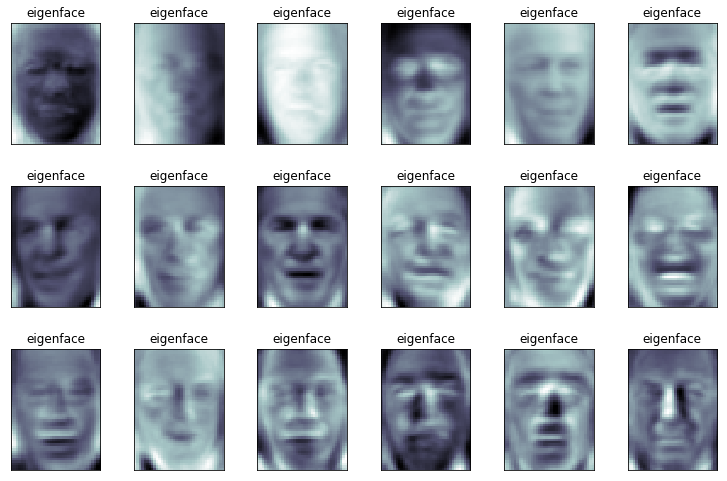

In [10]:
eigen_title=['eigenface']*18
plot_gallery(eigenfaces,eigen_title, 50, 37)

The components ("eigenfaces") are ordered by their importance from top-left to bottom-right. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training and test data onto the PCA basis:

In [11]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

(966, 150)
(322, 150)



These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face.

## Models
### Training a SVM
We'll perform support-vector-machine classification on this reduced dataset and perform an automated parameter search to find good values for Gamma and C:

In [12]:
from sklearn import svm
clf1 = svm.SVC(kernel='rbf', class_weight = 'balanced')
t0 = time.time()
clf1.fit(X_train_pca, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
print("done in {0:.3f}s".format(time.time() - t0))

done in 0.592s


plot a few of the test-cases with the labels learned from the training set:

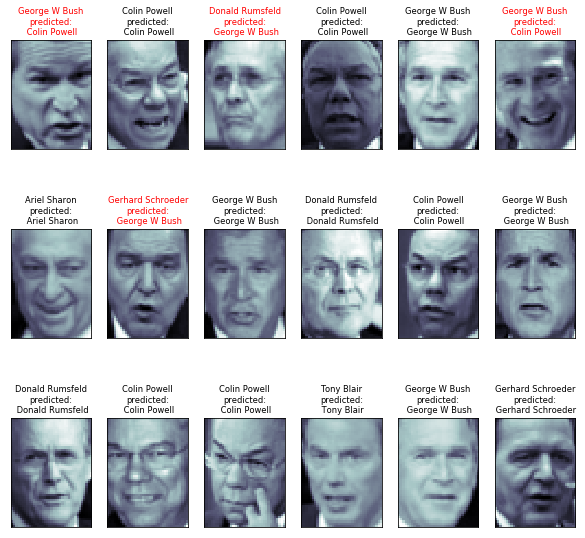

In [14]:
fig = plt.figure(figsize=(8, 6))
pl.subplots_adjust(bottom=0, left=.01, right=.99, top=1.20, hspace=.35)
for i in range(18):
    ax = fig.add_subplot(3, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape((50, 37)), cmap=plt.cm.bone)
    y_pred = clf1.predict(X_test_pca[i].reshape(1,-1))[0]
    color = 'black' if y_pred == y_test[i] else 'red'
    title = '%s\npredicted:\n %s' % (names[y_test[i]],lfw_people.target_names[y_pred])
    ax.set_title(title, fontsize='small', color=color)

Among the eighteen faces above, we successfully recognize fourteen faces. The total accuracy on the test data will be evaluated later.

### Data-driven hyper-parameters tuning using a Cross-Validated Grid Search

We're going to use a feature of sk-learn called GridSearchCV to find the optimal parameter settings rather than tuning them ourselves. We still have to supply potential settings, but it will figure out the best tuning with what we give it.



In [18]:
from sklearn.grid_search import GridSearchCV

param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf2 = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid)
# clf = GridSearchCV(svm, param_grid, scoring='f1', cv=cv, n_jobs=2)
# clf = clf.fit(X_train_pca, y_train)
# print("done in {0:.3f}s".format(time() - t0))
# print("Best estimator found by grid search:")
# print(clf.best_estimator_)

In [19]:
t0 = time.time()
clf2 = clf2.fit(X_train_pca, y_train)

In [20]:
print("done in {0:.3f}s".format(time.time() - t0))
print("Best estimator found by randomized hyper parameter search:")
print(clf2.best_params_)
print("Best parameters validation score: {:.3f}".format(clf2.best_score_))

done in 18.180s
Best estimator found by randomized hyper parameter search:
{'C': 1000.0, 'gamma': 0.001}
Best parameters validation score: 0.797


plot a few of the test-cases with the labels learned from the training set:

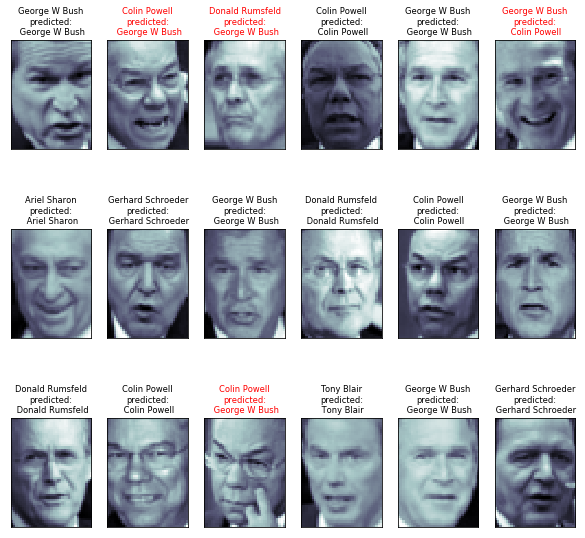

In [21]:
fig = plt.figure(figsize=(8, 6))
pl.subplots_adjust(bottom=0, left=.01, right=.99, top=1.20, hspace=.35)
for i in range(18):
    ax = fig.add_subplot(3, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape((50, 37)), cmap=plt.cm.bone)
    y_pred = clf2.predict(X_test_pca[i].reshape(1,-1))[0]
    color = 'black' if y_pred == y_test[i] else 'red'
    title = '%s\npredicted:\n %s' % (names[y_test[i]],lfw_people.target_names[y_pred])
    ax.set_title(title, fontsize='small', color=color)

The accuracy of the above 18 images is the same as the SVM. However, since we automate the search for the best conbination of parameters, it took much longer to fit the model.

#### How well did the model perform
We'll use two matrix reports to show how accurate our model was for each target. Some quick vocab for the first report:

- Accuracy: How many targets were identified corrently
- Precision: How many positive results were actually positive (or low false positives)
- Recall: How many negative results were actually negative (or low true negatives)
- F1-score:  Weighted average of precision and recall

Another interesting metric is the confusion matrix, which indicates how often any two items are mixed-up. 

In [31]:
import time
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print("Predicting the people names on the testing set using SVM")
t0 = time.time()
y_pred = clf1.predict(X_test_pca)
print("done in {0:.3f}s".format(time.time() - t0))
print("Accuracy Score :{0:.2f}%".format(accuracy_score(y_test, y_pred)*100) )
print(classification_report(y_test, y_pred, target_names=names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting the people names on the testing set using SVM
done in 0.076s
Accuracy Score :80.12%
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.61      0.76        28
     Colin Powell       0.61      0.94      0.74        63
  Donald Rumsfeld       0.91      0.83      0.87        24
    George W Bush       0.85      0.84      0.85       132
Gerhard Schroeder       0.83      0.75      0.79        20
      Hugo Chavez       1.00      0.41      0.58        22
       Tony Blair       0.90      0.82      0.86        33

      avg / total       0.84      0.80      0.80       322

[[ 17   8   0   3   0   0   0]
 [  0  59   1   1   0   0   2]
 [  0   2  20   2   0   0   0]
 [  0  20   0 111   1   0   0]
 [  0   1   1   2  15   0   1]
 [  0   4   0   7   2   9   0]
 [  0   2   0   4   0   0  27]]


In [30]:
print("Predicting the people names using hyperparameter tuning")
t0 = time.time()
y_pred2 = clf2.predict(X_test_pca)
print("done in {0:.3f}s".format(time.time() - t0))
print("Accuracy Score :{0:.2f}%".format(accuracy_score(y_test, y_pred2)*100) )
print(classification_report(y_test, y_pred2, target_names=names))
print(confusion_matrix(y_test, y_pred2, labels=range(n_classes)))

Predicting the people names using hyperparameter tuning
done in 0.059s
Accuracy Score :81.99%
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.75      0.81        28
     Colin Powell       0.78      0.83      0.80        63
  Donald Rumsfeld       0.70      0.79      0.75        24
    George W Bush       0.89      0.86      0.88       132
Gerhard Schroeder       0.73      0.80      0.76        20
      Hugo Chavez       0.89      0.73      0.80        22
       Tony Blair       0.72      0.79      0.75        33

      avg / total       0.83      0.82      0.82       322

[[ 21   4   0   2   1   0   0]
 [  2  52   1   2   0   2   4]
 [  0   2  19   2   0   0   1]
 [  1   8   5 114   1   0   3]
 [  0   0   1   1  16   0   2]
 [  0   0   0   4   2  16   0]
 [  0   1   1   3   2   0  26]]


## Conclusions

The f1-score and accuracy of hyper-parameters tuning model are higher than the first SVM model. So, I would choose the second model to identifying the names of face images for this dataset.

## Part II : Identify Emotion

## Data
The JAFFE (Japanese Female Facial Expression) is the database which contains 213 images of 7 facial expressions (neutral, sadness, surprise, happiness, fear, anger, and disgust) posed by 10 Japanese female models. Each image has been rated on 6 emotion adjectives by 60 Japanese subjects. More details can be found in http://www.kasrl.org/jaffe.html.

Here is the dataset of JAFFE. The original images are in .tiff. We converted them into .jpg for analysis. 

In [151]:
#Define Datapath
data_path = './jaffe/'
data_dir_list = os.listdir(data_path)

img_rows=256
img_cols=256
num_channel=1

num_epoch=10

img_data_list=[]
img_data_list1=[]


for dataset in data_dir_list:
    if dataset != '.DS_Store':
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            if img != '.DS_Store':
                im_path = data_path + dataset + '/'+ img
                input_img=cv2.imread(im_path)
                input_img1=cv2.imread(im_path)
                input_img1=cv2.cvtColor(input_img1, cv2.COLOR_BGR2GRAY)
                input_img_resize=cv2.resize(input_img,(128,128))
                input_img_resize1=cv2.resize(input_img1,(128,128))
                img_data_list.append(input_img_resize)
                img_data_list1.append(input_img_resize1)
            
                
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape


Loaded the images of dataset-HAPPY

Loaded the images of dataset-SAD

Loaded the images of dataset-FEAR

Loaded the images of dataset-SURPRISE

Loaded the images of dataset-NEUTRAL

Loaded the images of dataset-ANGRY

Loaded the images of dataset-DISGUST



(213, 128, 128, 3)

In [143]:
img_data1 = np.array(img_data_list1)
img_data1 = img_data1.astype('float32')
img_data1 = img_data1/255
img_data1.shape

(213, 128, 128)

Here are some of the images used in this dataset:

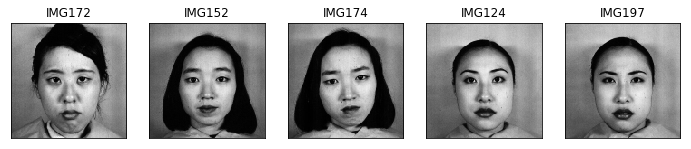

In [130]:
fs = (12, 12)
plt.figure(figsize=fs)
indices = np.random.randint(0, len(img_data)-1, 5)

for i,im in enumerate(img_data[indices]):
    plt.subplot(1, 5, i+1)
    plt.imshow(im, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    plt.title('IMG' + str(indices[i]))
plt.show()

## Exploratory Data Anlaysis

All the images are stored in img_data. Since there are 7 facial expressions, images will be labeled from 0 to 6 to represent angry, disgust, fear, happy, neutral, sad and surprise.

In [131]:
#Define the number of classes
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:29]=0 #30
labels[30:59]=1 #29
labels[60:92]=2 #32
labels[93:124]=3 #31
labels[125:155]=4 #30
labels[156:187]=5 #31
labels[188:]=6 #30

names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

def getLabel(id):
    return ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'][id]



### Convert the class label to one-hot encoding
A one hot encoding is a representation of categorical variables as binary vectors. This first requires that the class labels be mapped to integer values. Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

Since we will use CNN layer, converting the class label to one-hot encoding can help in both making the problem easier for the network to model.

In [132]:
# convert class labels to on-hot encoding# conve 
Y = np_utils.to_categorical(labels, num_classes)

After converting the class label to one-hot encoding, we shuffle the dataset to serve the purpose of reducing variance and make sure that models remain general and overfit less. After that, the dataset is splited into X_train, X_test, y_train, y_test.

In [133]:
#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)

In [134]:
img_data1=np.asarray(img_data_list)
img_data1.shape

(213, 128, 128, 3)

In [146]:
b = [i for i in range(0,55)]
b.append(255)

lbp_imgs = []
lbp_hists = []

for im in img_data1:
    aux = lbp(im, 8, 28, method='default')
    lbp_imgs.append(aux)
    
    aux2, _ = np.histogram(aux, bins=b)
    lbp_hists.append(aux2)

lbp_hists = np.asarray(lbp_hists)

## Models

### 1. CNN layer set
The CNN is a deep, feed-forward artificial neural network.

In Keras, we can just stack up layers by adding the desired layer one by one. At first, we add a first convolutional layer with Convolution2D() because we work with images. Max pooling operation is for spatial data. Dense layer that has a softmax activation function is needed for this multi-class classification problem.

In [144]:
# Defining the model

input_shape=img_data[0].shape

model = Sequential()

# Feature Extraction
# model.add(Convolution2D(32,3,3, border_mode='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(Convolution2D(32, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Convolution2D(64, 3, 3))
# model.add(Activation('relu'))
# # model.add(Convolution2D(64, 3, 3))
# # model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Convolution2D(128, 3, 3))
# model.add(Activation('relu'))
# # model.add(Convolution2D(128, 3, 3))
# # model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

#new Code
model.add(Convolution2D(6, 5, 5, input_shape=input_shape, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(16, 5, 5, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(120, 5, 5))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(84))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Classification
# model.add(Flatten())
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes))
# model.add(Activation('softmax'))

#Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

There are 3 layers in the model.The first layer has 6-3*3 filters. The second layer has 16-3*3 filters. The third layer has 120-3*3 filters. Here is the summary of some parameters (weights and biases) in each layer and also the total parameters in model.

In [137]:
model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 6)       456       
_________________________________________________________________
activation_11 (Activation)   (None, 128, 128, 6)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 16)        2416      
_________________________________________________________________
activation_12 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 120)       48120     
__________

True

In [30]:
# Training
hist = model.fit(X_train, y_train, batch_size=7, nb_epoch=30, verbose=1, validation_data=(X_test, y_test),callbacks=callbacks_list)

Train on 181 samples, validate on 32 samples
Epoch 1/30
181/181 [==============================] - 9s 47ms/step - loss: 2.0293 - acc: 0.1381 - val_loss: 1.9430 - val_acc: 0.1563
Epoch 2/30
181/181 [==============================] - 6s 34ms/step - loss: 1.9303 - acc: 0.2265 - val_loss: 1.9172 - val_acc: 0.1563
Epoch 3/30
181/181 [==============================] - 7s 38ms/step - loss: 1.8721 - acc: 0.2376 - val_loss: 1.8407 - val_acc: 0.1875
Epoch 4/30
181/181 [==============================] - 7s 38ms/step - loss: 1.6191 - acc: 0.3923 - val_loss: 1.6702 - val_acc: 0.3125
Epoch 5/30
181/181 [==============================] - 8s 42ms/step - loss: 1.4437 - acc: 0.4751 - val_loss: 1.4784 - val_acc: 0.3438
Epoch 6/30
181/181 [==============================] - 7s 38ms/step - loss: 1.1521 - acc: 0.5746 - val_loss: 1.4243 - val_acc: 0.5313
Epoch 7/30
181/181 [==============================] - 6s 34ms/step - loss: 0.9915 - acc: 0.6243 - val_loss: 1.1479 - val_acc: 0.5938
Epoch 8/30
181/181 [====

<Figure size 432x288 with 0 Axes>

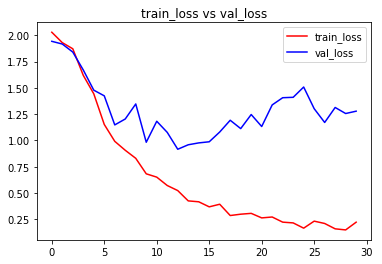

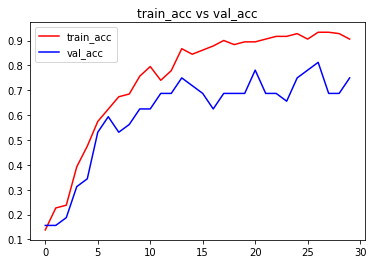

<Figure size 432x288 with 0 Axes>

In [31]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

Test Loss: 1.2784466743469238
Test accuracy: 0.75
(1, 128, 128, 3)
[[9.3916256e-04 4.6685743e-03 6.9048104e-04 8.6547179e-06 9.9369228e-01
  2.5067533e-07 6.1819134e-07]]
[4]
[[0. 0. 0. 0. 1. 0. 0.]]


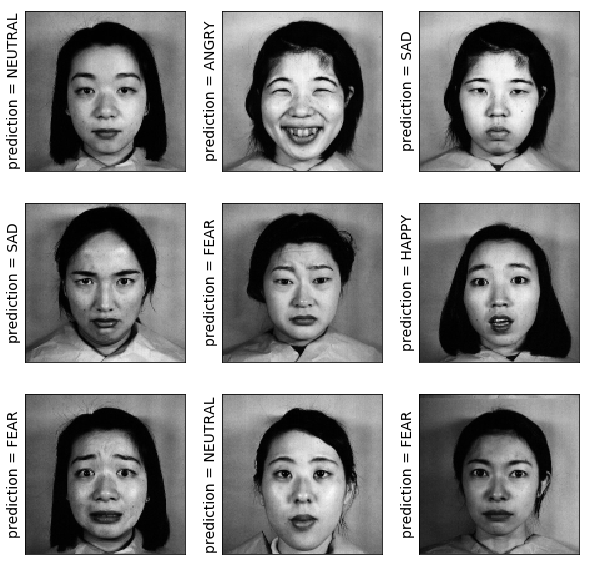

In [33]:
# Evaluating the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(model.predict(test_image))
print(model.predict_classes(test_image))
print(y_test[0:1])

res = model.predict_classes(X_test[:9])
plt.figure(figsize=(10, 10))

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_test[i],cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('prediction = %s' % getLabel(res[i]), fontsize=14)
# show the plot
plt.show()

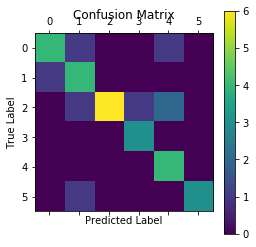

In [34]:
from sklearn.metrics import confusion_matrix
results = model.predict_classes(X_test)
cm = confusion_matrix(np.where(y_test == 1)[1], results)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### 2. K-Means

In [164]:
X = np.asarray(lbp_hists)
kf = KF(n_splits=30, shuffle=True).split(X)

train_indices, test_indices =  next(kf)

print('Training images:', train_indices, '\n')
print('Testing images:', test_indices, '\n')

X_train = X[train_indices]
y_train = labels[train_indices]

X_test = X[test_indices]
y_test = labels[train_indices]

knn = KNN(n_neighbors=1).fit(X_train, y_train)
class_prediction = knn.predict(X_test)

print('Predicted Classes:', class_prediction, '\n')
print('Real Classes:', labels[test_indices], '\n')

Training images: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  83  84  85  86  87  88  89  90  92  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 200 201 202 203 204 205
 206 207 208 209 210 211 212] 

Testing images: [ 33  62  82  91  93 170 179 199] 

Predicted Classes: [2 1 2 2 2 6 5 6] 

Real Classes: [1 2 2 2 3 5 5 6] 



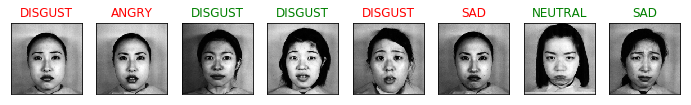

In [173]:
plt.figure(figsize=fs)

for i,im in enumerate(img_data1[test_indices]):
    plt.subplot(1, 8, i+1)
    plt.imshow(im, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
    emotions = np.array(['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'])
    
    title = str(emotions[class_prediction[i]-1])
    
    if title == str(emotions[labels[test_indices][i]-1]):
        plt.title(title, color='green')
    else:
        plt.title(title, color='red')
plt.show()

In [175]:
knn = KNN(n_neighbors=1)
score_knn = cross_val_score(knn, X, labels, cv=10)
print('KNN MEAN PERFORMANCE: ',str(np.mean(score_knn)*100)[:5] + '%')

KNN MEAN PERFORMANCE:  44.49%
